### One step multivariate model

In this notebook, we demonstrate how to:

- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next step ahead (time t+1) in the time series. This model uses recent values of temperature, as well as load, as the model input.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition1. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load and temperature data.

1Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import sys
sys.path.append('..')
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
# Load data into Pandas dataframe
data_dir = 'data'
energy = load_data(data_dir)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
# define Date to train, validation, test datasets
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

- Data Inspection

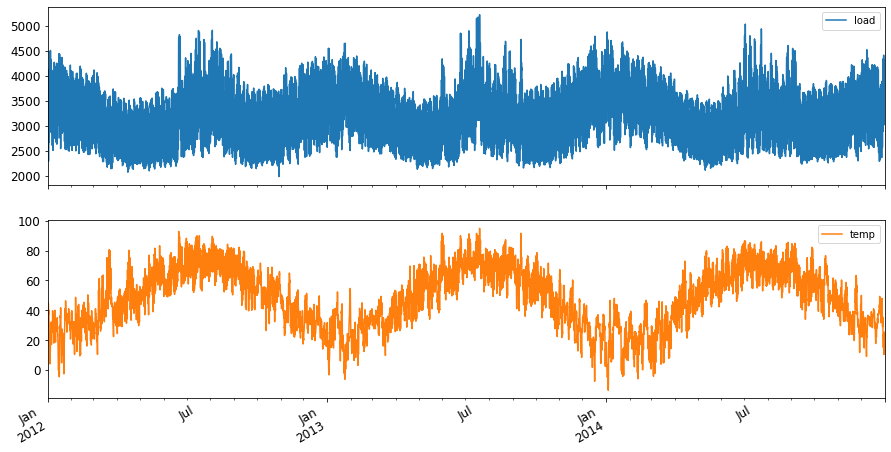

In [4]:
energy.plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

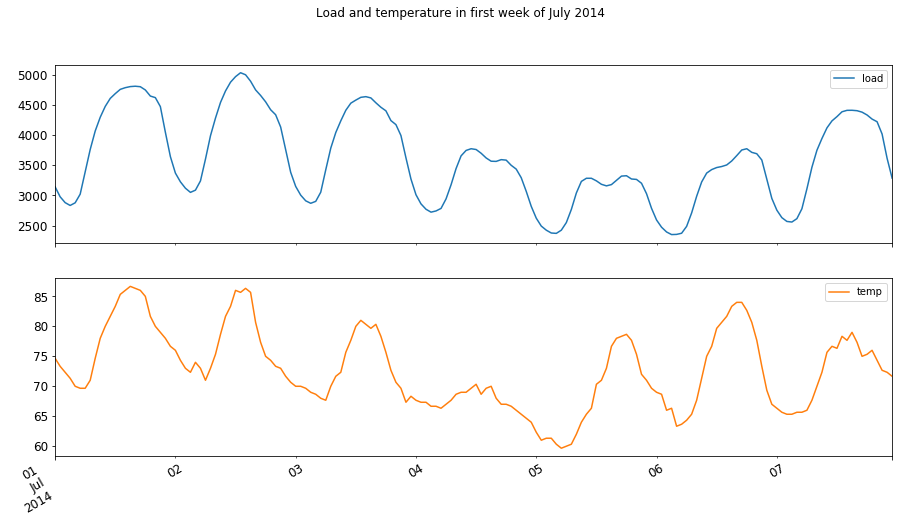

In [5]:
energy['2014-07-01':'2014-07-07'].plot(y=['load', 'temp'], title='Load and temperature in first week of July 2014' , subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

**The input for each sample is a vector of the previous 6 hours** of the energy load (T=6). 

The choice of this value was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)

In [6]:
T = 6
HORIZON = 1

In [7]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# here we need to scale the two input features
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, {'X':(range(-T+1, 1), ['load', 'temp'])})

In [8]:
train_inputs.dataframe.head()

tensor              target    X                                               \
feature                  y load                          temp                  
time step              t+1  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4  t-3  t-2   
2012-01-01 05:00:00   0.18 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43 0.40 0.41   
2012-01-01 06:00:00   0.23 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40 0.41 0.42   
2012-01-01 07:00:00   0.29 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41 0.42 0.41   
2012-01-01 08:00:00   0.35 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42 0.41 0.40   
2012-01-01 09:00:00   0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41 0.40 0.39   

tensor                         
feature                        
time step            t-1    t  
2012-01-01 05:00:00 0.42 0.41  
2012-01-01 06:00:00 0.41 0.40  
2012-01-01 07:00:00 0.40 0.39  
2012-01-01 08:00:00 0.39 0.39  
2012-01-01 09:00:00 0.39 0.43

## Validation Set

In [9]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## RNN Forecasting - MODEL 1

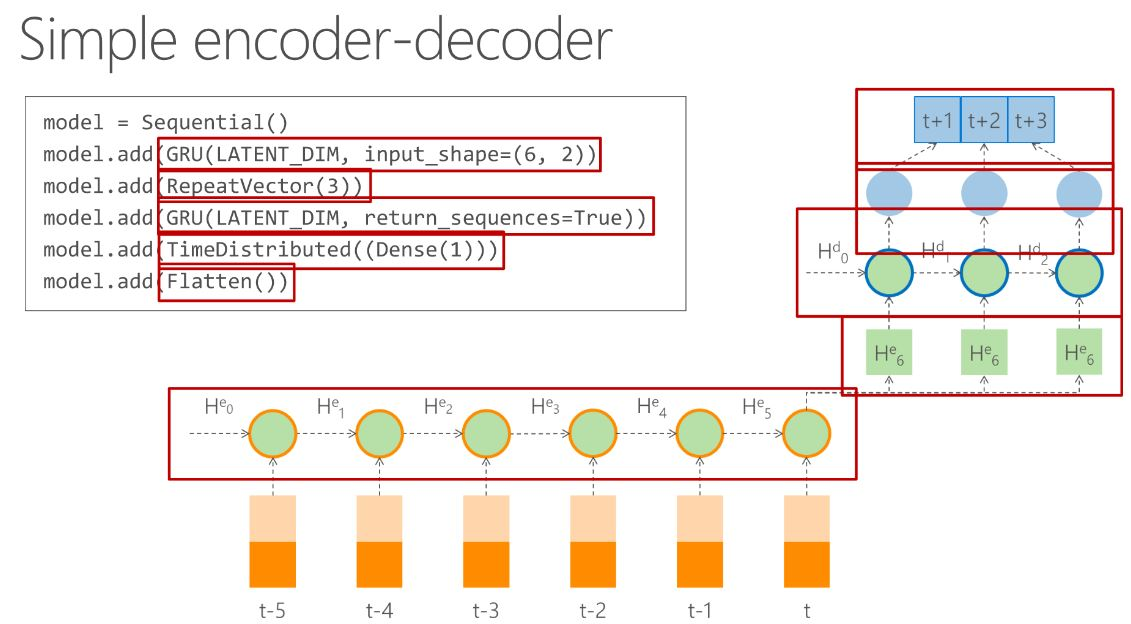

In [10]:
Image("images/simple_encoder_decoder_1.JPG")

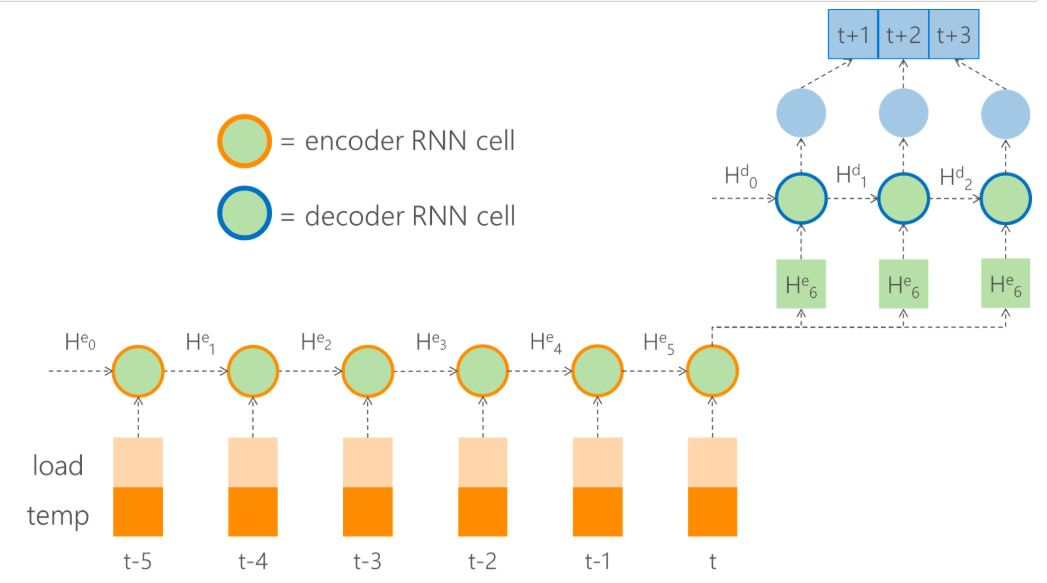

In [11]:
Image("images/simple_encoder_decoder.JPG")

In [12]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
model = Sequential()

model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

model.compile(optimizer='RMSprop', loss='mse')
model.summary()

W0229 23:32:26.302877 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0229 23:32:26.331993 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0229 23:32:26.335875 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0229 23:32:26.906877 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\optimizers.py:79

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 5)              165       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [15]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

W0229 23:32:28.617908 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0229 23:32:28.625876 60620 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 23370 samples, validate on 1463 samples
Epoch 1/10
23370/23370 [==============================] - 4s 169us/step - loss: 0.0111 - val_loss: 0.0014
Epoch 2/10
23370/23370 [==============================] - 2s 101us/step - loss: 9.5194e-04 - val_loss: 7.3975e-04
Epoch 3/10
23370/23370 [==============================] - 2s 101us/step - loss: 6.6779e-04 - val_loss: 5.2119e-04
Epoch 4/10
23370/23370 [==============================] - 2s 102us/step - loss: 6.0828e-04 - val_loss: 6.0223e-04
Epoch 5/10
23370/23370 [==============================] - 2s 105us/step - loss: 5.8323e-04 - val_loss: 5.0597e-04
Epoch 6/10
23370/23370 [==============================] - 3s 108us/step - loss: 5.7800e-04 - val_loss: 4.8125e-04
Epoch 7/10
23370/23370 [==============================] - 2s 104us/step - loss: 5.7199e-04 - val_loss: 9.7979e-04
Epoch 8/10
23370/23370 [==============================] - 3s 110us/step - loss: 5.6605e-04 - val_loss: 6.1482e-04
Epoch 9/10
23370/23370 [=======================

## Evaluate Model

In [16]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [17]:
predictions = model.predict(test_inputs['X'])

In [18]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,652.86","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,910.23","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,169.02","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,293.09","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,424.18","3,436.00"


In [19]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
Name: APE, dtype: float64

In [20]:
mape(eval_df['prediction'], eval_df['actual'])

0.018649566682915047

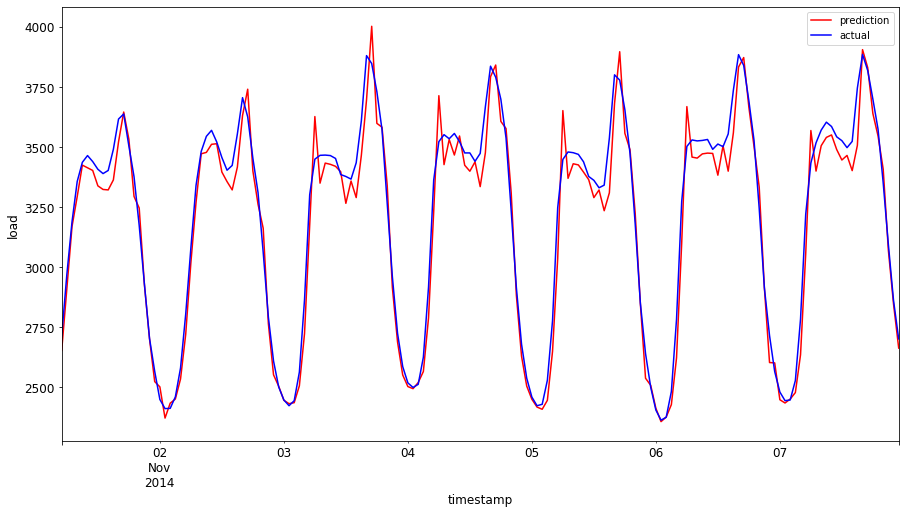

In [21]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## RNN Forecasting - MODEL 2

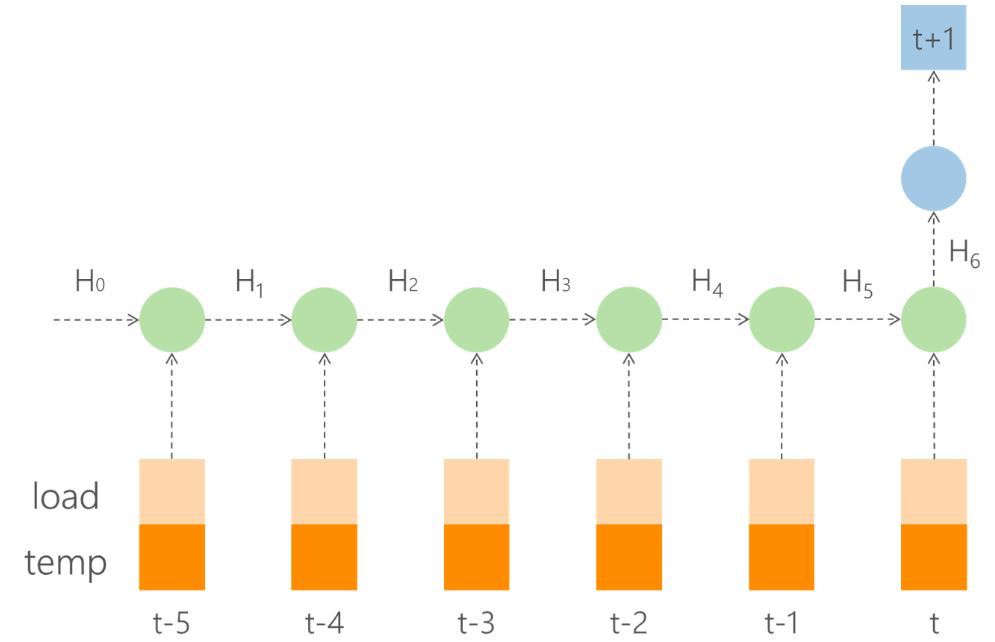

In [22]:
Image("images/one_step_multivariate.JPG")

In [23]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [24]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

In [25]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))


model.compile(optimizer='RMSprop', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 5)                 120       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [26]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = model.fit(train_inputs['X'],
                    train_inputs['target'],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(valid_inputs['X'], valid_inputs['target']),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 3s 149us/step - loss: 0.0050 - val_loss: 0.0021
Epoch 2/50
23370/23370 [==============================] - 2s 106us/step - loss: 0.0013 - val_loss: 7.7163e-04
Epoch 3/50
23370/23370 [==============================] - 2s 89us/step - loss: 6.7844e-04 - val_loss: 5.3776e-04
Epoch 4/50
23370/23370 [==============================] - 2s 94us/step - loss: 5.7419e-04 - val_loss: 6.2769e-04
Epoch 5/50
23370/23370 [==============================] - 2s 105us/step - loss: 5.4747e-04 - val_loss: 5.1908e-04
Epoch 6/50
23370/23370 [==============================] - 3s 129us/step - loss: 5.3605e-04 - val_loss: 4.8319e-04
Epoch 7/50
23370/23370 [==============================] - 3s 132us/step - loss: 5.3087e-04 - val_loss: 6.6089e-04
Epoch 8/50
23370/23370 [==============================] - 2s 93us/step - loss: 5.2638e-04 - val_loss: 5.1779e-04
Epoch 9/50
23370/23370 [==============================

### Evaluate Model

In [27]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

predictions = model.predict(test_inputs['X'])

eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,716.11","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,975.44","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,240.72","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,374.29","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,500.51","3,436.00"


In [28]:
mape(eval_df['prediction'], eval_df['actual'])

0.016972548486350658

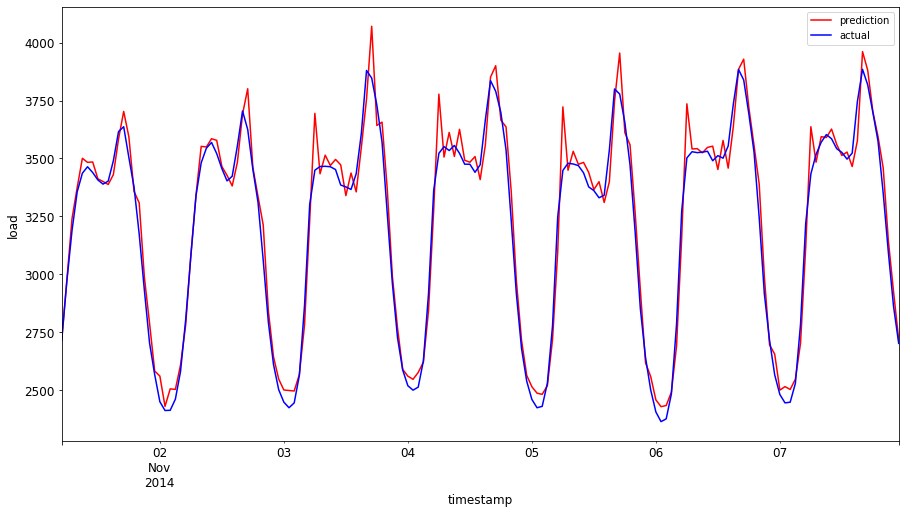

In [29]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()